# NOTES
## Preprocessing steps
1. Define bad and dead channels
    - note: manual inspection first? The authors seemed to go in loops and find the bad channels after all the preprocessing are done (artifacts found in autorejects and IC rejections)
For (each participant):
2. Downsample (1000Hz -> 250Hz)
    - note: original data has 260Hz low pass filter
3. Bandpass Filter (0.1, 30Hz)
4. Remove 50Hz. Original paper: notch Filter (50Hz (48, 52, 1))
5. Remove bad channels (if more than 4: remove participant)
6. Rerefenrence (mastoid)
7. Isolate some data to run ICA (epoching? starting with each new cue)
8. Remove bad trials (find artifacts)
9. Run ICA
10. Perform auto-rejection per ICLabel
11. Interpolation

>NOTE: two-pass preprocessing: go through the preprocessing steps once and then see if there is still bad channels remaining. if so, mark them and start over again.

## To do list
- compare with the results with follow the exact same pipeline as the authors
- process all the participants
- make a separate config file
- (done)need to set a random seed for ICA, otherwise the value is slightly different everytime
- statistical analysis
- cleanup codes, add comments

https://mne.tools/stable/auto_tutorials/preprocessing/40_artifact_correction_ica.html
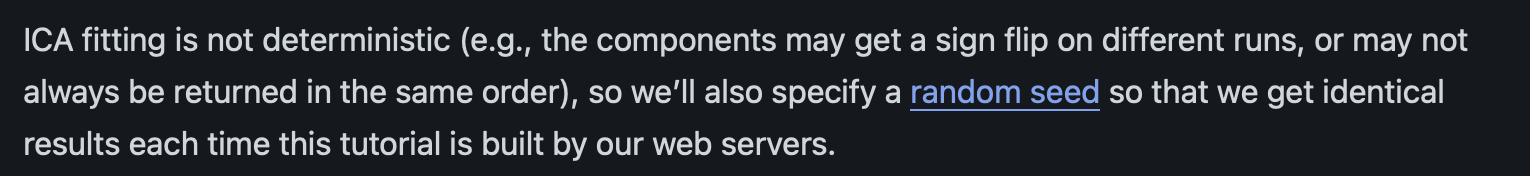

## Things to consider
- do we include the participants that are marked as non-learners by the author? or do we change the criteria a bit? (e.g. 60% -> 55%)
- do we stick to the criteria for early trial rejection? maybe instead of eliminating we can compare between learners and non-learners
- aside from eye blinks, should we reject other ic components? (e.g., heartbeat, muscle, channel noise, other)
- maybe analysis across time to show the effect of learning?

**NOTES**
- nonLearners = [3 5 9 12 20 24 25 29 30 32 33]

## Results under current condition
- condition: IC rejection - eye blink > 50%

| Subject ID | Bad Channels | Notes |
|---|---|---|
| 27 | N/A | |
| 28 | Fp1 | |
| 29 | N/A | |
| 30 (non learner) | N/A | pretty obvious channel noise at Fp1, but does not surpass the threshold \(15%\)|
| 31 | N/A | regular troughs that look like heartbeat but not shown in ic anaylsis. need double check |
| 32 (non learner) | N/A  \(author: TP10\) | line noise present after bandpass - prove that notch filter is still necessary|
| 33 (non learner) | N/A | muscle artifacts present but then no epochs is rejected after ica |
| 34 | N/A | channel noise and heart beat present but no epochs is rejected after ica |
| 35 | 'Fp1', 'TP9', 'TP10', 'Fp2' | TP9 and TP10 are needed for interpolation. Probably bc 'other' in ICA, ugly artifacts across all channels in the plot. Need to change the current IC rejeciton criteria if we follow the same pipeline|
| 36 | N/A | channel noise present. the regular troughs again. again only a few epochs are rejected after ica |
| 37 | N/A | the regular troughs again. again only a few epochs are rejected after ica|
| 38 | N/A | heart beat present but no epochs is rejected after ica |
| | General notes | From manual inspection there seem to be still artifacts (looks regular) after cleaning (not sure if its normal brain reaction after sitmulus or eyeblinks or heartbeats, need to take a second look.)

# Configs

In [66]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [67]:
import mne
from mne_bids import (BIDSPath,read_raw_bids)
import sys
sys.path.insert(0,'.')
import os


import ccs_eeg_utils
import config
from tools import get_valid_input
from visualization import show_single_psd, psd_compare, iclabel_visualize, plot_erp
from s00_add_reference import add_reference_channel
from s01_downsample_filter import down_sampling, band_filter, notch_filter, zapline_filter
from s02_drop_bad_channels import drop_bad_channels, reref
from s03_07_trial_rejection import trial_rejection_cust, trial_rejection_mne
from s04_ICA import get_ica, get_iclabel, iccomponent_removal, iccomponent_removal_author, iccomponent_removal_new
from s05_interpolation import interpolation
from s06_early_trial_removal import exclude_early_trials
from s07_epoching import epoching, epoching_cust
from s08_find_bad_channels import find_bad_channels
from s09_make_erps import get_evoked, get_evoked_difference
from s10_rewp_calculation import rewp_calculation

# Set the configs

In [68]:
ACTIVE_PIPELINE = get_valid_input(
    'Select active pipeline (options: original/proposed): ',
    list(config.PIPELINES.keys())
)

USER = get_valid_input(
    'Select the user (options: qian/zheng): ',
    list(config.BIDS_ROOT.keys())
)

SUBJECT = get_valid_input(
    'Select the subject id (options: 27 - 28): ',
    list(config.SUBJECT_INFO.keys())
)

FIRST_RUN = get_valid_input(
    'Is this the first run for the subject? (options: True/False): ',
    ['True', 'False']
)

INSPECTION_MODE = get_valid_input(
    'Do you want to inspect the intermediate results? (options: True/False): ',
    ['True', 'False']
)

Input accepted:original
Input accepted:qian
Input accepted:27
Input accepted:True
Input accepted:False


In [69]:
### set up paths and read in data
cfg = config.PIPELINES[ACTIVE_PIPELINE]
root = config.BIDS_ROOT[USER]

bids_path = BIDSPath(subject=SUBJECT, task='casinos',
                     datatype='eeg', suffix='eeg',
                     root=root)

# read the file
raw = read_raw_bids(bids_path)
# fix the annotations readin
ccs_eeg_utils.read_annotations_core(bids_path,raw)

### montage setup
montage_site2_path = os.path.join(root, 'code', config.LOCS_FILENAME['site2']) 
montage_site2 = mne.channels.read_custom_montage(montage_site2_path)
montage_common_path = os.path.join(root, 'code', config.LOCS_FILENAME['common'])
montage_common = mne.channels.read_custom_montage(montage_common_path)

### Dictionary for epoching conditions
epoch_dict = config.CONDITIONS_DICT['feedback_locked']

### Subject info list
subject_info = config.SUBJECT_INFO

Extracting parameters from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_eeg.vhdr...
Setting channel info structure...
Reading events from /Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/reward_dataset/sub-27/eeg/sub-27_task-casinos_events.tsv.
The event "Stimulus" refers to multiple event values.Creating hierarchical event names.
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  4
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/S  3
    Renaming event: Stimulus -> Stimulus/S  5
    Renaming event: Stimulus -> Stimulus/S  6
    Renaming event: Stimulus -> Stimulus/S  1
    Renaming event: Stimulus -> Stimulus/S  2
    Renaming event: Stimulus -> Stimulus/

/var/folders/t4/tpd64s9d2xb_cdt_fwtwlr480000gn/T/ipykernel_52812/3589596553.py:10: RuntimeWarning: Unable to map the following column(s) to to MNE:
participant: 27
date: 18-Mar-2022 13:55:40
handedness: R
order: 50-50 mixed 80-20
stimuli: a lemon an orange
  raw = read_raw_bids(bids_path)


# Load the dataset

In [70]:
#raw.plot()     # visualize raw data
#raw.get_data()  # extract data as numpy
raw.load_data()  # load to memory

Reading 0 ... 3161619  =      0.000 ...  3161.619 secs...


<RawBrainVision | sub-27_task-casinos_eeg.eeg, 31 x 3161620 (3161.6 s), ~747.8 MiB, data loaded>

>NOTE: from manual inspection, Fp1 and Fp2 have obvious eye blinking artifacts. T7 and T8 seem to have muscle artifacts. (but leave it as it is right now)

# Add Reference

>NOTE: theres a differece in ERP value w/ and w/o re-reference

In [71]:
raw = add_reference_channel(raw, 'Fz')  # add Fz as reference channel

# Set the Montage

In [72]:
raw.set_montage(montage_site2, match_case=False)

<RawBrainVision | sub-27_task-casinos_eeg.eeg, 32 x 3161620 (3161.6 s), ~771.9 MiB, data loaded>

# Downsample

In [73]:
eeg_down = down_sampling(raw)

Original Sampling Rate: 1000.0 Hz
New Sampling Rate: 250.0 Hz


# Bandpass

In [74]:
eeg_band = band_filter(eeg_down)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 s)



# Remove 50Hz Noise

## Option 1: Notch filter

Original setting:  `EEG = pop_eegfiltnew(EEG, 48, 52,[],1)`

In [75]:
eeg_band_notch = notch_filter(eeg_band)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1651 samples (6.604 s)



## Option 2: Zapline filter

In [76]:
if INSPECTION_MODE == True:
    eeg_band_zap = zapline_filter(eeg_band)

    # for sanity test
    #NOTE: when applied on the downsample eeg (not band filtered), zapline does remove the peak at 50Hz (check if zapline is really working)
    eeg_down_zap = zapline_filter(eeg_down)


# Examine the Effect of Filtering

## Raw vs. Downsampled vs. Bandpass-filtered

In [77]:
if INSPECTION_MODE == True:
    show_single_psd(raw, title="PSD for Raw EEG")
    show_single_psd(eeg_down, title="PSD for Downsampled EEG")
    show_single_psd(eeg_band, title="PSD for Bandpass-filtered EEG")


>NOTE: as shown on the plot, after band filter the line noise at 50Hz is barely visible

## Bandpass-filtered vs. Band+Notch vs. Band+Zapline

In [78]:
if INSPECTION_MODE == True:
    psd_compare((eeg_band, eeg_band_notch, eeg_band_zap), labels=("eeg_band", "eeg_band_notch", "eeg_band_zap"), title="Comparison of Filter Effects for 50Hz")

>NOTE: The leftover noise on 50Hz is negaligable and Zapline is not doing much after the bandpass filter. Choose notch?

In [79]:
if INSPECTION_MODE == True:
    show_single_psd(eeg_band_zap, title="PSD after bandpass&notch&zapline")

In [80]:
if INSPECTION_MODE == True:
    show_single_psd(eeg_down_zap, title="PSD for Zap-filtered (no bandpass) EEG")     # show that zapline can indeed remove 50Hz effectively if there is no bandpass applied before it

# Drop Bad Channels

>NOTE: not quite sure but i think they dropped the bad channel for ICA analysis, but need a copy (with bad channels) for interpolation

(need to re ananlysie after setting a random seed for ICA)

- subj 27: None
- subj 28: Fp1
- subj 35: TP9

In [81]:
if FIRST_RUN:
    eeg_ica = eeg_band_notch
else: 
    eeg_ica = drop_bad_channels(subject_info[SUBJECT]['bad_channels'], eeg_band_notch)   #input: bad channels from previous run, eeg

# Re-referencing

>NOTE: tba - reason for choosing mastoid

If only use one channel for reference, the reference channel should be dropped otherwise would influence trail rejection

In [82]:
eeg_ica = reref(eeg_ica)

Average Reference: Keeping both.
EEG channel type selected for re-referencing
Applying a custom ('EEG',) reference.


# Cleaning in Time (Trial Rejection)

In [83]:
### get the dictionary for the events
evts, evts_dict = mne.events_from_annotations(eeg_ica)
evts_dict_stim = {k: evts_dict[k] for k in evts_dict.keys() if k in config.CONDITIONS_DICT['onset_locked']}

if ACTIVE_PIPELINE == 'original':
    rejection_params = config.PIPELINES['original']['rejection_params']['ica']
    trials, rejection_info = trial_rejection_cust(eeg_ica, evts, evts_dict_stim, **rejection_params)
else: # proposed pipeline
    rejection_params = config.PIPELINES['proposed']['rejection_params']['ica']
    trials = trial_rejection_mne(eeg_ica, evts, evts_dict_stim, **rejection_params)
    # trials_mne.plot_drop_log()

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
Dropped 22 epochs: 0, 230, 240, 261, 266, 270, 276, 277, 278, 279, 282, 283, 284, 285, 286, 287, 310, 316, 327, 332, 335, 384


# ICA analysis

Difference between 3 ICA methods:
- Runica (infomax)
- Picard
- Fastica

>NOTE: need to add random seed, for ICA calculation introduce randomness and the results may be different every time

>NOTE: the authors used 'runica' -> 'infomax'

IClabel_componnet:
https://github.com/mne-tools/mne-icalabel/blob/main/mne_icalabel/label_components.py


https://mne.tools/mne-icalabel/dev/generated/api/mne_icalabel.iclabel.iclabel_label_components.html

> Q: does this have big impact on the results?

RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).

Fitting ICA to data using 32 channels (please be patient, this may take a while)
Using data from preloaded Raw for 410 events and 751 original time points ...
Selecting by non-zero PCA components: 31 components
Computing Extended Infomax ICA
Using data from preloaded Raw for 410 events and 751 original time points ...
Fitting ICA took 22.8s.
Using data from preloaded Raw for 410 events and 751 original time points ...


/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:35: RuntimeWarning: The provided Epochs instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  ic_labels = label_components(trials, ica, method=method)
/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/visualization.py:102: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(hspace=0.6, wspace=0.1, bottom=0.15)


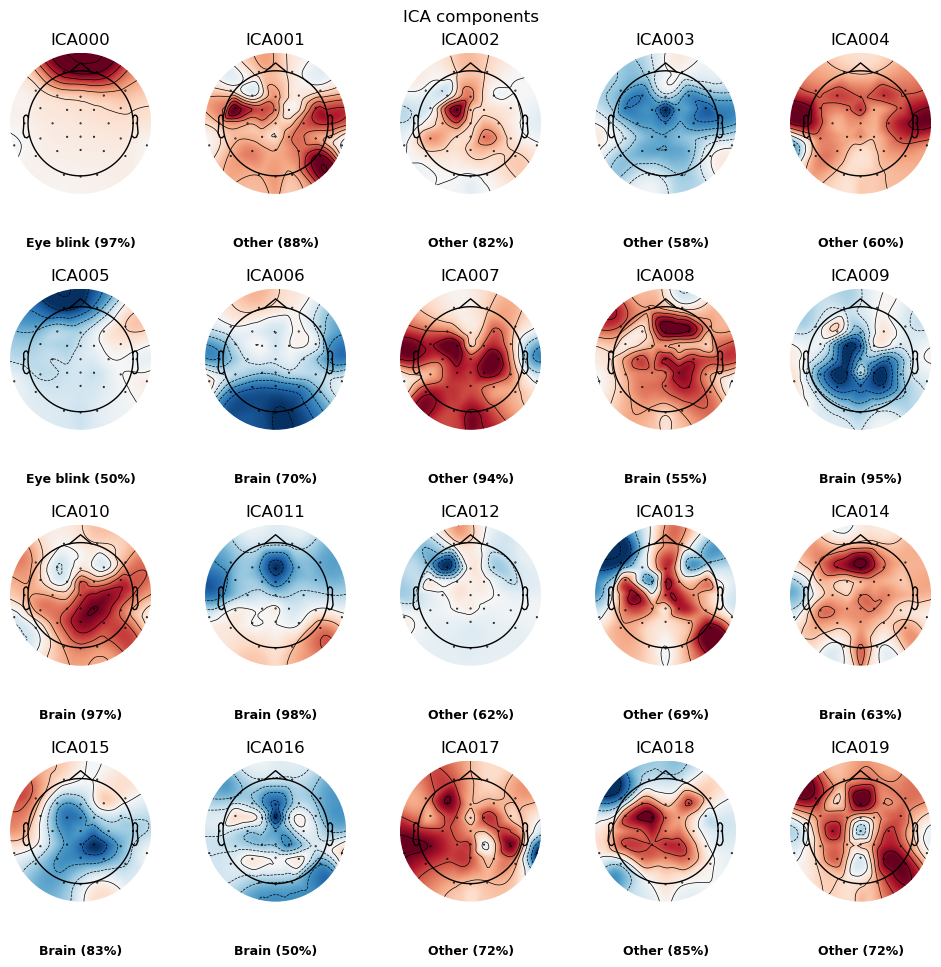

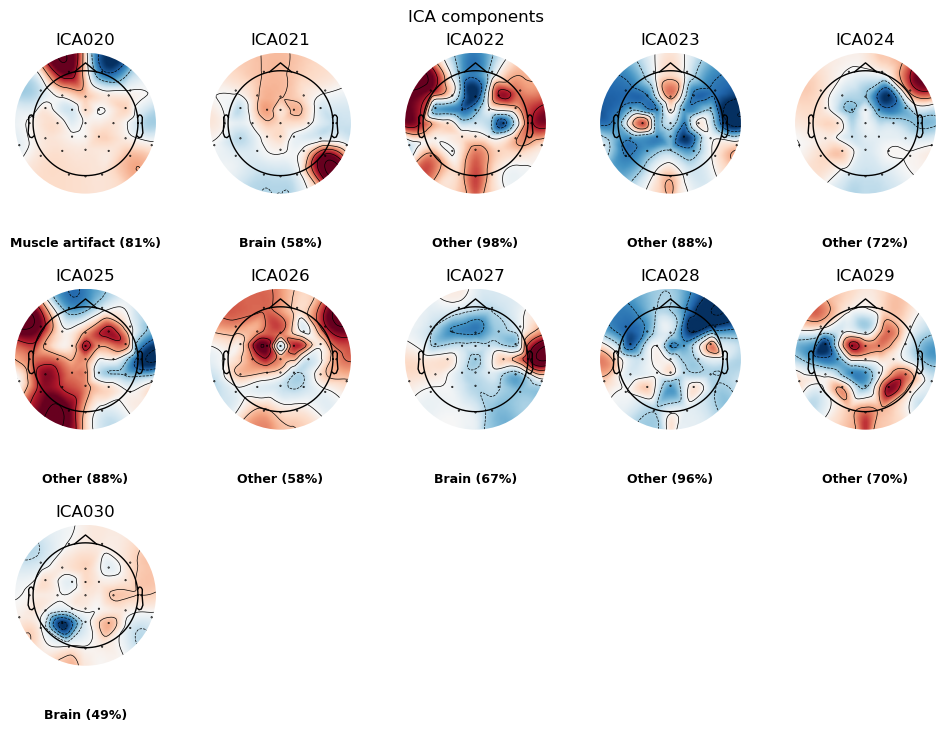

/Users/qianyueli/Documents/UniStuttgart/26WI/EEG/EEG_project/EEG_Reward-Processing_ERP/scripts/s04_ICA.py:85: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  all_labels = iclabel_label_components(eeg, ica)


Applying ICA to Raw instance
    Transforming to ICA space (31 components)
    Zeroing out 3 ICA components
    Projecting back using 32 PCA components


In [84]:
if ACTIVE_PIPELINE == 'original':
    ica = get_ica(trials, config.PIPELINES['original']['ica_method'])
    ic_labels = get_iclabel(trials, ica, method='iclabel')
    iclabel_visualize(ica, ic_labels, trials)
    eeg_band_notch = iccomponent_removal_author(eeg_band_notch, ica)
else: # proposed pipeline
    ica = get_ica(trials, config.PIPELINES['proposed']['ica_method'])
    ic_labels = get_iclabel(trials, ica, method='iclabel')
    iclabel_visualize(ica, ic_labels, trials)
    eeg_band_notch = iccomponent_removal_new(eeg_band_notch, ica)

# Interpolation

In [85]:
eeg_band_notch = interpolation(eeg_band_notch)

No bad channels marked for interpolation


# Misc

## (TBD) Set to common locs and extra channel deletion

In [86]:
# locs_common = 'common.locs'
# commonlocs_path = os.path.join(bids_root, 'code', locs_common)      

# # 1. Load your custom montage
# common_montage = mne.channels.read_custom_montage(commonlocs_path)

# # 1. Identify missing channels
# missing_channels = [ch for ch in common_montage.ch_names if ch not in eeg_band_notch.ch_names]

# # 2. Add them (Initializes them with zeros)
# if missing_channels:
#     # This adds the NAMES to the list
#     eeg_band_notch.add_reference_channels(missing_channels)
    
#     # CRITICAL: This updates the internal 'info' structure so the index is valid
#     # and prevents the 'IndexError' you saw on line 22
#     eeg_band_notch.set_channel_types({ch: 'eeg' for ch in missing_channels})

# # 3. Apply the custom montage
# # This populates the 'loc' (coordinates) for those channels
# eeg_band_notch.set_montage(common_montage, on_missing='ignore')

# # 4. Interpolate correctly
# # Mark ONLY the newly added channels as bad
# eeg_band_notch.info['bads'] = missing_channels

# # We use origin=(0., 0., 0.) to ensure the mathematical matrix 
# # doesn't produce NaNs/Infs during the pinv(C) calculation
# eeg_band_notch.interpolate_bads(reset_bads=True, origin=(0., 0., 0.))


# # for participants of site 2, need to remove ['O1','O2','CPz'] channels to make sure it has same num of channels as site 1
# channels_to_remove = ['O1','O2','CPz']
# eeg_band_notch.drop_channels(channels_to_remove, on_missing='ignore')

# # left 29 channels which is different from what they have stated in make_erp (they set 30 channels)

## Remove the first few trials from each task

In [87]:
eeg_final = exclude_early_trials(eeg_band_notch, config.PIPELINES[ACTIVE_PIPELINE]['early_trial_deletion'])

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
Excluded 148 events (first 10 trials of each block).


>NOTE: 
- in theory, 3 tasks x 10 trials x 6 events = 180 events to be exlude
- but there might be some invalid response or to fast/slow reponses that do not have response/feedback

# Epoching & find leftover artifacts

In [88]:
if ACTIVE_PIPELINE == 'original':
    rejection_params = config.PIPELINES['original']['rejection_params']['erp']
    bad_channel_criteria = config.PIPELINES['original']['bad_channels_rejection_criteria']
    epochs_all, rejection_info = epoching_cust(epoch_dict, eeg_final, **rejection_params)
    find_bad_channels(epochs_all, reject_criteria=bad_channel_criteria, custom=True, rejection_info=rejection_info)
else: # proposed pipeline
    rejection_params = config.PIPELINES['proposed']['rejection_params']['erp']
    epochs_all = epoching(epoch_dict, eeg_final, **rejection_params)
    find_bad_channels(epochs_all, reject_criteria=config.PIPELINES['proposed']['bad_channels_rejection_criteria'], custom=False)

Used Annotations descriptions: [np.str_('Comment:Active Shielding: On'), np.str_('Stimulus:S  1'), np.str_('Stimulus:S  2'), np.str_('Stimulus:S  3'), np.str_('Stimulus:S  4'), np.str_('Stimulus:S  5'), np.str_('Stimulus:S  6'), np.str_('Stimulus:S  7'), np.str_('Stimulus:S 11'), np.str_('Stimulus:S 12'), np.str_('Stimulus:S 13'), np.str_('Stimulus:S 14'), np.str_('Stimulus:S 15'), np.str_('Stimulus:S 16'), np.str_('Stimulus:S 17'), np.str_('Stimulus:S 21'), np.str_('Stimulus:S 22'), np.str_('Stimulus:S 23'), np.str_('Stimulus:S 24'), np.str_('Stimulus:S 25'), np.str_('Stimulus:S 26'), np.str_('Stimulus:S 27'), np.str_('Stimulus:S 31'), np.str_('Stimulus:S 32'), np.str_('Stimulus:S 33'), np.str_('Stimulus:S 34'), np.str_('Stimulus:S 35'), np.str_('Stimulus:S 36'), np.str_('Stimulus:S 37')]
Dropped 0 epochs: 
--- Channel Rejection Summary ---
Fp1: 0/398 drops (0.0%)
F3: 0/398 drops (0.0%)
F7: 0/398 drops (0.0%)
FC5: 0/398 drops (0.0%)
FC1: 0/398 drops (0.0%)
FCz: 0/398 drops (0.0%)
C3: 

# Make ERP

use trimmed mean
compare with the original method?

In [89]:
all_evokeds = get_evoked(epoch_dict, epochs_all, proportiontocut=config.PIPELINES[ACTIVE_PIPELINE]['evoked_proportiontocut'])

Using data from preloaded Raw for 66 events and 201 original time points ...
Using data from preloaded Raw for 66 events and 201 original time points ...
Using data from preloaded Raw for 34 events and 201 original time points ...
Using data from preloaded Raw for 32 events and 201 original time points ...
Using data from preloaded Raw for 42 events and 201 original time points ...
Using data from preloaded Raw for 25 events and 201 original time points ...
Using data from preloaded Raw for 77 events and 201 original time points ...
Using data from preloaded Raw for 56 events and 201 original time points ...


In [90]:
if INSPECTION_MODE == True:
    # butterfly graph for one condition
    evoked_Low_Low_Win = all_evokeds['Low-Low Win']
    evoked_Low_Low_Win.plot();

# RewP Calculation

In [91]:
rewp_calculation(all_evokeds, epoch_dict)

RewP Mean Amplitude: 0.84 µV
RewP Peak-to-Peak: 4.12 µV


# RewP Plotting

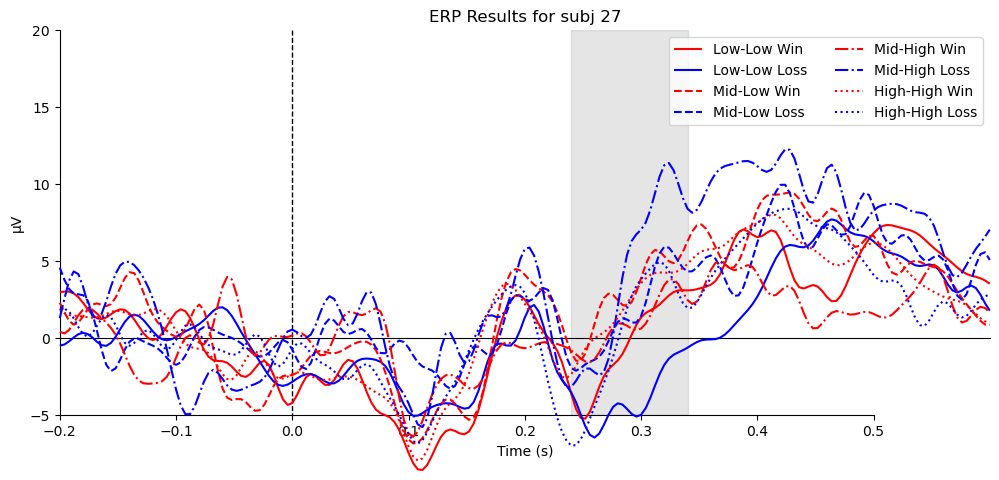

In [ ]:
#NOTE: need to set y-axis to a fixed range for better comparison across subjects
plot_erp(all_evokeds, ylim=[-5, 20], diff=False, title=f"ERP Results for - Subject {SUBJECT} (Pipeline: {ACTIVE_PIPELINE})");

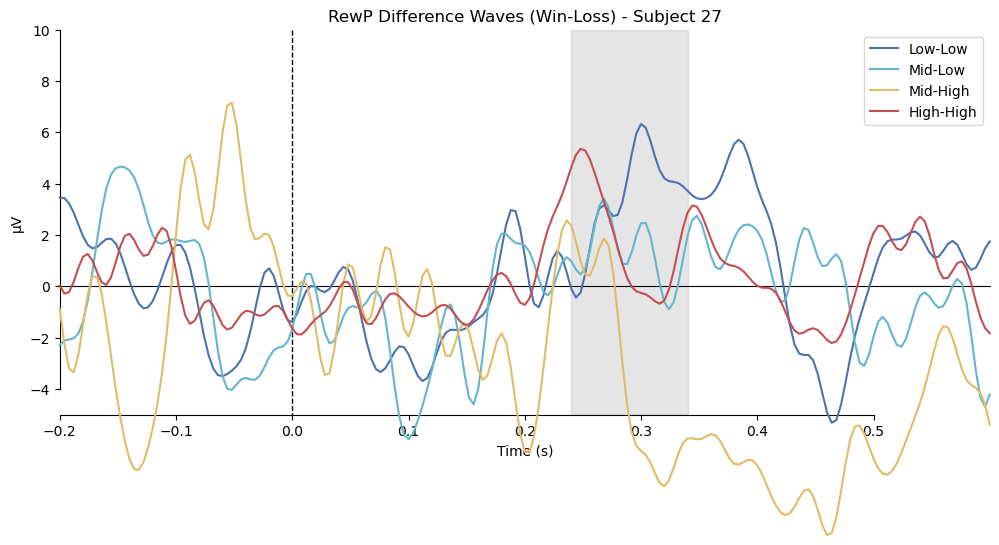

In [ ]:
diff_evokeds = get_evoked_difference(all_evokeds)
plot_erp(diff_evokeds, diff=True, title=f"RewP Difference Waves (Win-Loss) - Subject {SUBJECT} (Pipeline: {ACTIVE_PIPELINE})")

^not extended version for ica (alright but no visible difference before and after)
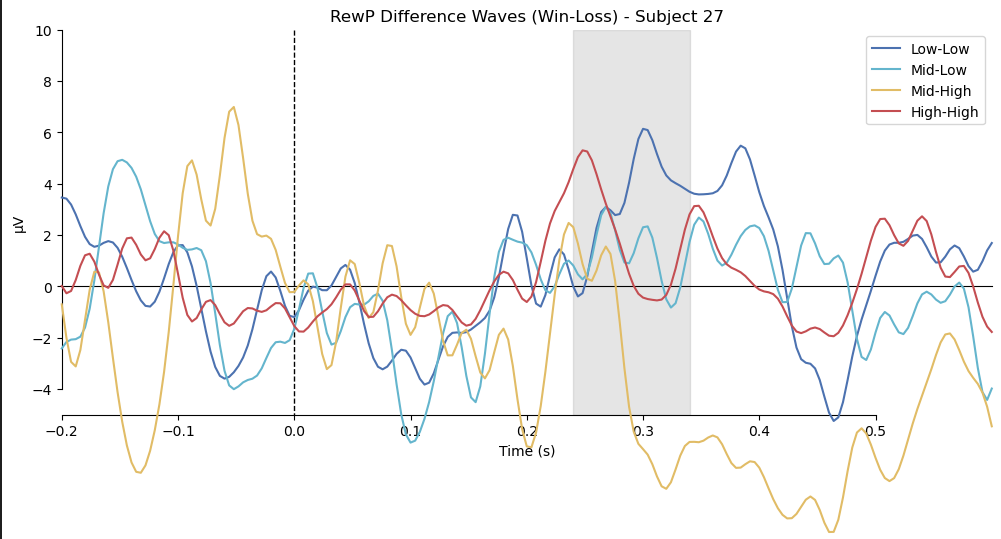